# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

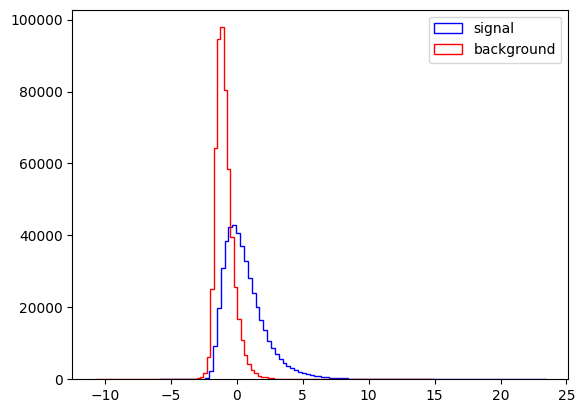

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

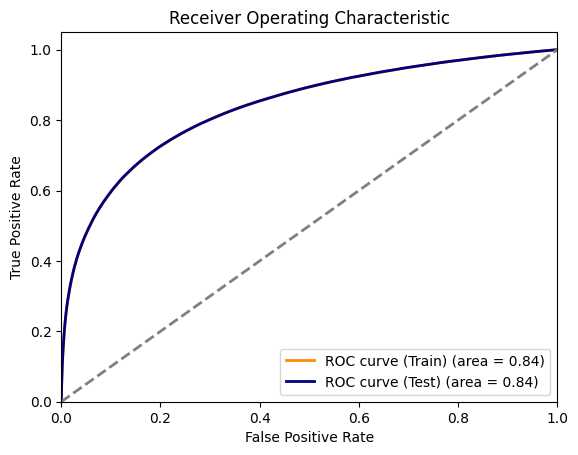

In [7]:
from sklearn.metrics import roc_curve, auc

# For training sample
y_train_pred = Fisher.predict_proba(X_Train)[:, 1]  # Probability of positive class
fpr_train, tpr_train, _ = roc_curve(y_Train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

# For test sample
y_test_pred = Fisher.predict_proba(X_Test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_Test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (Train) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='ROC curve (Test) (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Part a
There is no bias since the training and test set overlap each other, if one were to be significantly higher than the other then there would be bias.

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

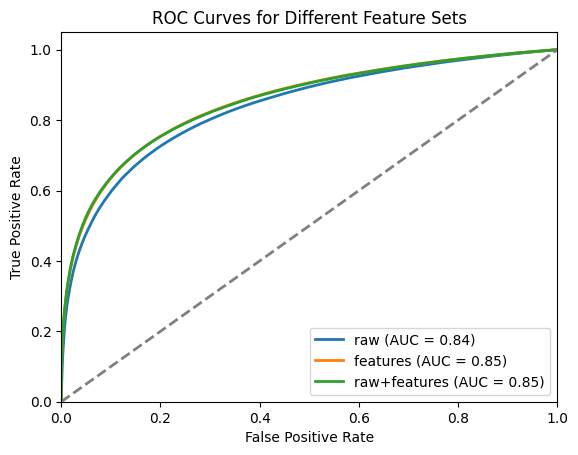

In [8]:
import sklearn.discriminant_analysis as DA

# transformed features 
X_train_features = X_Train.copy()  
X_train_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_train_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)
X_test_features = X_Test.copy()
X_test_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_test_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)

# create combined features (raw + transformed)
X_train_raw_features = pd.concat([X_Train, X_train_features], axis=1)  
X_test_raw_features = pd.concat([X_Test, X_test_features], axis=1)

Fisher = DA.LinearDiscriminantAnalysis()

# train and evaluate with raw features
Fisher.fit(X_Train, y_Train)  # Changed X_Train_raw to X_Train
y_pred_raw = Fisher.predict_proba(X_Test)[:, 1]  # Changed X_test_raw to X_Test
fpr_raw, tpr_raw, _ = roc_curve(y_Test, y_pred_raw)
roc_auc_raw = auc(fpr_raw, tpr_raw)

# train and evaluate with transformed features
Fisher.fit(X_train_features, y_Train)  
y_pred_transformed = Fisher.predict_proba(X_test_features)[:, 1]  
fpr_transformed, tpr_transformed, _ = roc_curve(y_Test, y_pred_transformed)
roc_auc_transformed = auc(fpr_transformed, tpr_transformed)

# train and evaluate with combined features
Fisher.fit(X_train_raw_features, y_Train)  
y_pred_combined = Fisher.predict_proba(X_test_raw_features)[:, 1]  
fpr_combined, tpr_combined, _ = roc_curve(y_Test, y_pred_combined)
roc_auc_combined = auc(fpr_combined, tpr_combined)

plt.plot(fpr_raw, tpr_raw, lw=2, label=f'raw (AUC = {roc_auc_raw:.2f})')
plt.plot(fpr_transformed, tpr_transformed, lw=2, label=f'features (AUC = {roc_auc_transformed:.2f})')
plt.plot(fpr_combined, tpr_combined, lw=2, label=f'raw+features (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Feature Sets')
plt.legend(loc="lower right")
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.


-----------------------------------------------------------

Part a:


The classifiers I chose were:
Linear Regression,
Random Forest,
Naive Bayes.

Reasoning: Linear regression is a good baseline model and is fast to train. Random Forests combine multiple decision trees to improve prediction accuracy and reduce overfitting. Naive bayes classifiers are simple and are suitable for large datasets, it provides probabilty for each class prediction which helps understand the model, and it is also a good baseline model.

These classifiers represent different approaches to classification (linear, tree-based, and ensemble). This provides a good basis for comparison. They are also known for good performance in. classification tasks.

In [11]:
# Part a
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.model_selection import train_test_split

X = df[VarNames[1:]]  # Features 
y = df["signal"]  # Target variable 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Define the models 
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10),
    "GaussianNB": GaussianNB()  
}

# Train the models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

LogisticRegression trained.
RandomForest trained.
GaussianNB trained.


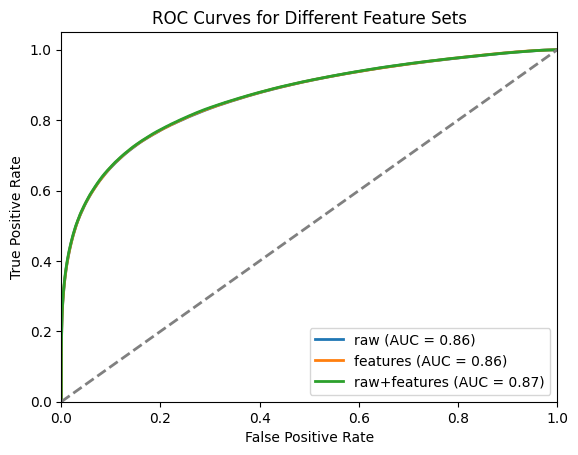

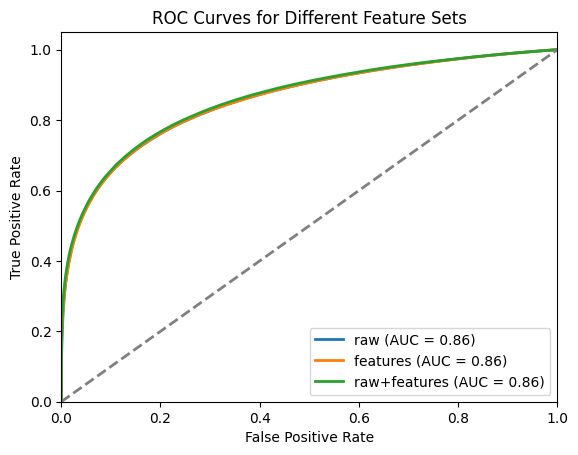

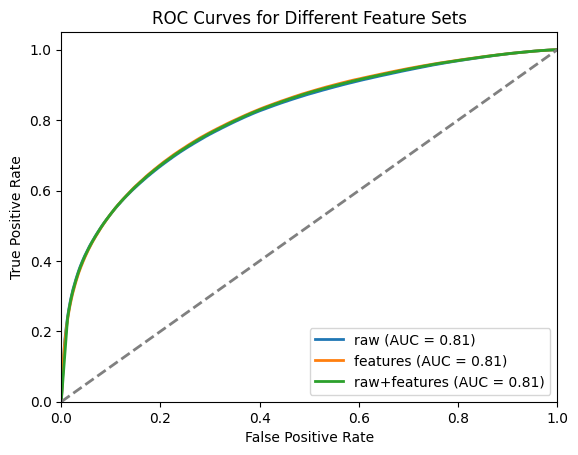

In [15]:
# Part b
def compare_classifier_performance(classifier, X_train, y_train, X_test, y_test, VarNames):
    # Transformed features
    X_train_features = X_train.copy()
    X_train_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_train_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)
    X_test_features = X_test.copy()
    X_test_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_test_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)

    # Combined features (raw + features)
    X_train_raw_features = pd.concat([X_train, X_train_features], axis=1)
    X_test_raw_features = pd.concat([X_test, X_test_features], axis=1)

    # Train and evaluate with raw features
    classifier.fit(X_train, y_train)
    y_pred_raw = classifier.predict_proba(X_test)[:, 1]
    fpr_raw, tpr_raw, _ = roc_curve(y_test, y_pred_raw)
    roc_auc_raw = auc(fpr_raw, tpr_raw)

    # Train and evaluate with features
    classifier.fit(X_train_features, y_train)
    y_pred_transformed = classifier.predict_proba(X_test_features)[:, 1]
    fpr_transformed, tpr_transformed, _ = roc_curve(y_test, y_pred_transformed)
    roc_auc_transformed = auc(fpr_transformed, tpr_transformed)

    # Train and evaluate with combined features
    classifier.fit(X_train_raw_features, y_train)
    y_pred_combined = classifier.predict_proba(X_test_raw_features)[:, 1]
    fpr_combined, tpr_combined, _ = roc_curve(y_test, y_pred_combined)
    roc_auc_combined = auc(fpr_combined, tpr_combined)

    # Plot ROC curves
    plt.plot(fpr_raw, tpr_raw, lw=2, label=f'raw (AUC = {roc_auc_raw:.2f})')
    plt.plot(fpr_transformed, tpr_transformed, lw=2, label=f'features (AUC = {roc_auc_transformed:.2f})')
    plt.plot(fpr_combined, tpr_combined, lw=2, label=f'raw+features (AUC = {roc_auc_combined:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Feature Sets')
    plt.legend(loc="lower right")
    plt.show()

rf_model = models["RandomForest"]  
compare_classifier_performance(rf_model, X_train, y_train, X_test, y_test, VarNames) 
lr_model = models["LogisticRegression"]
compare_classifier_performance(lr_model, X_train, y_train, X_test, y_test, VarNames)
nb_model= models["GaussianNB"]
compare_classifier_performance(nb_model, X_train, y_train, X_test, y_test, VarNames)

In [16]:
# Part C
rf_model = models["RandomForest"]

X_train_features = X_train.copy()
X_train_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_train_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)
X_test_features = X_test.copy()
X_test_features[['l_1_pT', 'l_2_pT', 'MET']] = np.log(X_test_features[['l_1_pT', 'l_2_pT', 'MET']] + 1)

rf_model.fit(pd.concat([X_train, X_train_features], axis=1), y_train) # Train on combined features
y_pred_proba = rf_model.predict_proba(pd.concat([X_test, X_test_features], axis=1))[:, 1] # Predict on combined features
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

max_significance = 0
optimal_threshold = 0

for i in range(len(thresholds)):
    signal_efficiency = tpr[i]
    background_efficiency = fpr[i]
    if background_efficiency > 0: # Avoid division by zero
        significance = signal_efficiency / np.sqrt(background_efficiency)
        if significance > max_significance:
            max_significance = significance
            optimal_threshold = thresholds[i]

print(f"Maximal significance: {max_significance:.2f}")
print(f"Optimal threshold: {optimal_threshold:.2f}")

Maximal significance: 11.74
Optimal threshold: 1.00


In [19]:
# Get predicted probabilities
y_probs = rf_model.predict_proba(pd.concat([X_test, X_test_features], axis=1))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ns = np.sum(y_test == 1)  # Number of signal events
nb = np.sum(y_test == 0)  # Number of background events

significances = (tpr * ns) / np.sqrt(fpr * nb + tpr * ns)  
max_sig_index = np.nanargmax(significances)  # Handle potential NaN values

max_significance = significances[max_sig_index]
optimal_threshold = thresholds[max_sig_index]

print(f"Maximal significance: {max_significance:.2f}")
print(f"Optimal threshold: {optimal_threshold:.2f}")

Maximal significance: 519.80
Optimal threshold: 0.39


/var/folders/2g/bzsspqkj2kn59n94r77dmyfw0000gn/T/ipykernel_1364/2070302281.py:8: RuntimeWarning: invalid value encountered in divide
  significances = (tpr * ns) / np.sqrt(fpr * nb + tpr * ns)


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

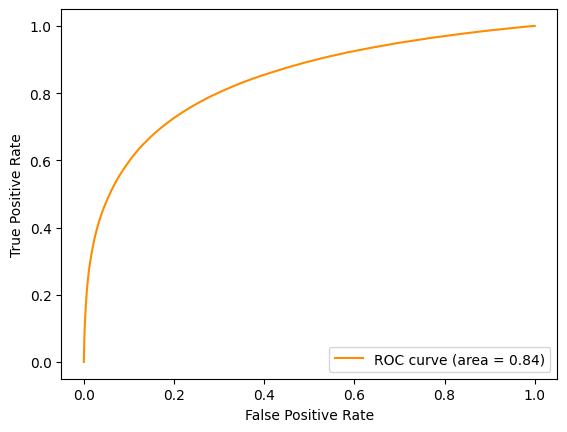

In [25]:
from sklearn.metrics import roc_curve, auc
Fisher.fit(X_Train.values, y_Train)
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test.values))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc

X_train_raw_features = pd.concat([X_train, X_train_features.add_suffix('_transformed')], axis=1)  
X_test_raw_features = pd.concat([X_test, X_test_features.add_suffix('_transformed')], axis=1) 

classifier = RandomForestClassifier(n_estimators=50, max_depth=10)
classifier.fit(X_train_raw_features, y_train)

# Predict probabilities and labels on the test set using X_test_raw_features
y_pred_proba = classifier.predict_proba(X_test_raw_features)[:, 1]
y_pred = classifier.predict(X_test_raw_features)

# Calculate metrics
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)

best_threshold = 0
max_significance = 0
for threshold in np.linspace(0, 1, 101):
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((y_test == 1) & (y_pred_thresh == 1))
    fp = np.sum((y_test == 0) & (y_pred_thresh == 1))
    significance = tp / np.sqrt(tp + fp) if (tp + fp) > 0 else 0
    if significance > max_significance:
        max_significance = significance
        best_threshold = threshold

table_data = [[tpr[1], fpr[1], roc_auc, precision, recall, f1, accuracy, max_significance, best_threshold]]
headers = ["TPR", "FPR", "ROC AUC", "Precision", "Recall", "F1 Score", "Accuracy", "Max Significance", "Optimal Threshold"]
metrics_table = pd.DataFrame(table_data, columns=headers)  
print(metrics_table.to_string(index=False)) 

     TPR  FPR  ROC AUC  Precision   Recall  F1 Score  Accuracy  Max Significance  Optimal Threshold
0.000002  0.0 0.865366   0.830441 0.695056  0.756741  0.795523        520.241049               0.39
